In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *
from diy_stable_diffusion.augment import *
from diy_stable_diffusion.accel import *
from diy_stable_diffusion.fid import *

from fastprogress.fastprogress import progress_bar

from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

classifier_model = torch.load('../../p2/nbs/models/data_aug2.pkl')
del(classifier_model[8])
del(classifier_model[7])

@inplace
def transformi(b):
    b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) * 2 - 1 for o in b[xl]]
bs = 256
tds = dsd.with_transform(transformi)

dls=DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

ie =ImageEval(classifier_model, dls, cbs=[DeviceCB(), SingleBatchCB()])

ie.feats.shape

from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

# using DDPM scheduler

class UNet(UNet2DModel): pass

sampling_model = torch.load('models/2024-01-12-fashion_ddpm3_25_jfshfioa.pkl')

sz = (2048, 1, 32, 32)
'ok'

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

'ok'

In [4]:
xb,yb=next(iter(dls.train))

In [5]:
xb.shape

torch.Size([256, 1, 32, 32])

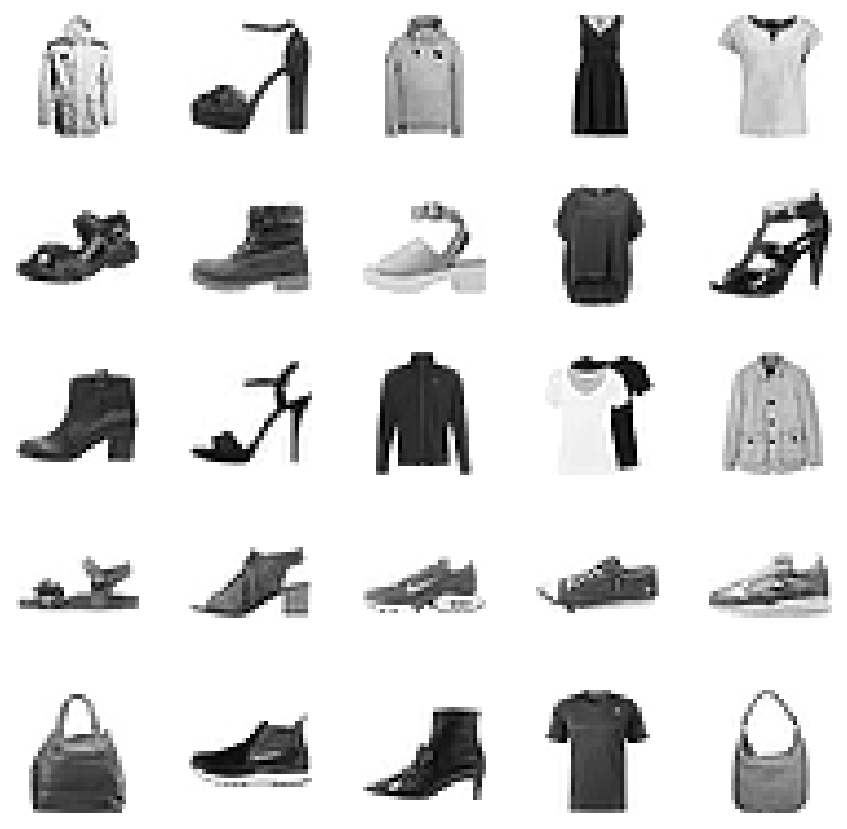

In [6]:
show_images(xb[:25])

In [8]:
sched = DDPMScheduler(beta_end=0.01)

In [16]:
x_t = torch.randn((32,1,32,32)).cuda()
t=999
t_batch = torch.full((len(x_t), ), t, device=x_t.device, dtype=torch.long)
with torch.no_grad():
    noise = sampling_model(x_t, t_batch).sample

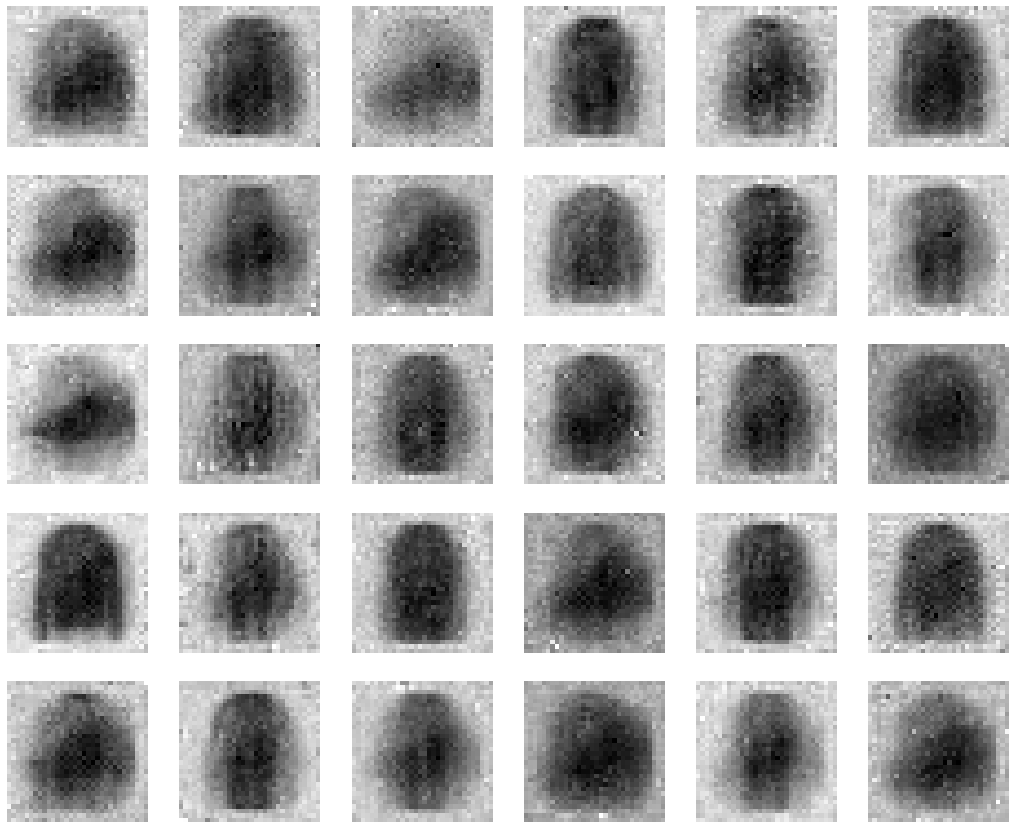

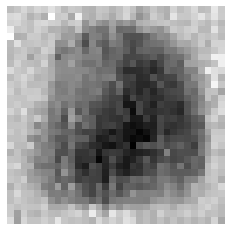

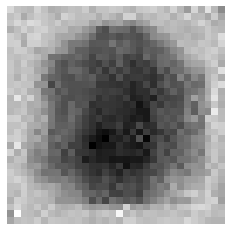

In [21]:
show_images(x_t - noise)

In [22]:
res = sched.step(noise, t, x_t)

In [30]:
%%time
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad():
        noise = sampling_model(x_t, t).sample
    
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 19min 43s, sys: 10min 32s, total: 30min 15s
Wall time: 30min 14s


In [31]:
final_samples= preds[-1]
final_samples.min(),final_samples.max()

(tensor(-0.5441), tensor(0.6880))

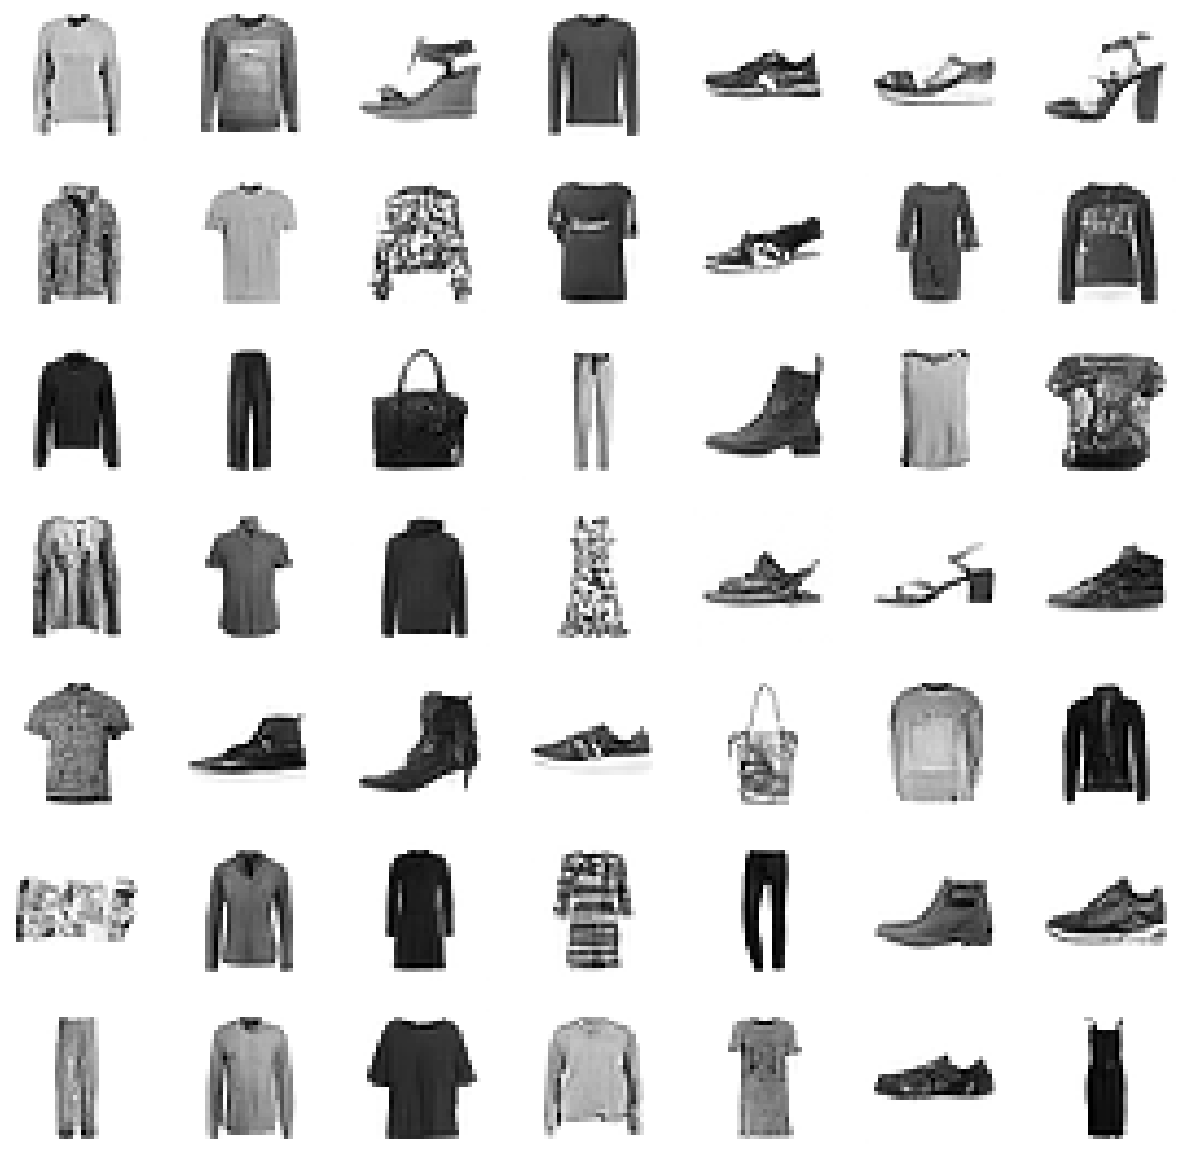

In [33]:
show_images(final_samples[:49].clamp(-.5, 0.5) * 2)

# DDIM scheduler

In [7]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    
    for t in progress_bar(sched.timesteps):
        '''
        Note: torch.no_grad() is very important because
        gradient info takes huge amount of cuda memory and
        causes cuda OOM errors that are hard to undo (clean_mem
        doesn't really work)
        '''
        with torch.no_grad():
            pred_noise = model(x_t, t).sample
        '''
        kwargs is supported in order to pass in, for example, "eta" parameter
        
        I believe the field is called prev_sample because we're going from
        x_t to x_(t-1), the "previous" image as t goes backward from large to
        small values down to x_0.
        '''
        x_t = sched.step(pred_noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    
    return preds

In [11]:
clean_mem()

In [9]:
import gc
gc.collect()

0

In [11]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

preds=diff_sample(sampling_model, sz, sched, eta=1.0)
s=(preds[-1]*2).clamp(-1,1)

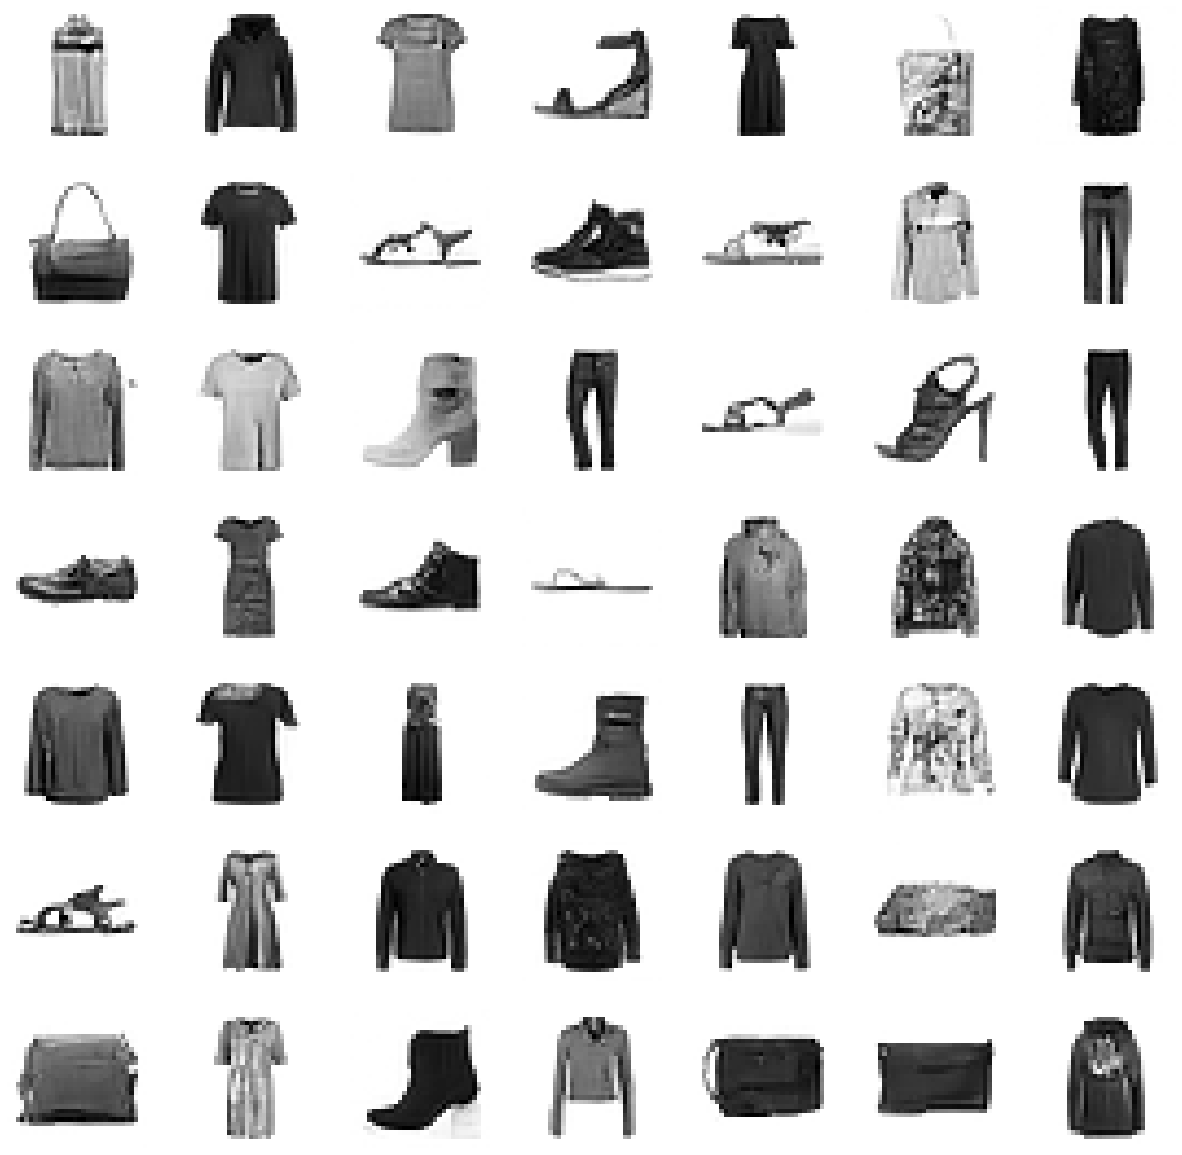

In [12]:
show_images(s[:49])

In [15]:
sched.set_timesteps(50)
preds=diff_sample(sampling_model, (49,1,32,32), sched, eta=1.0)
s=(preds[-1]*2).clamp(-1,1)

[(tensor(-0.5140), tensor(0.5341))]


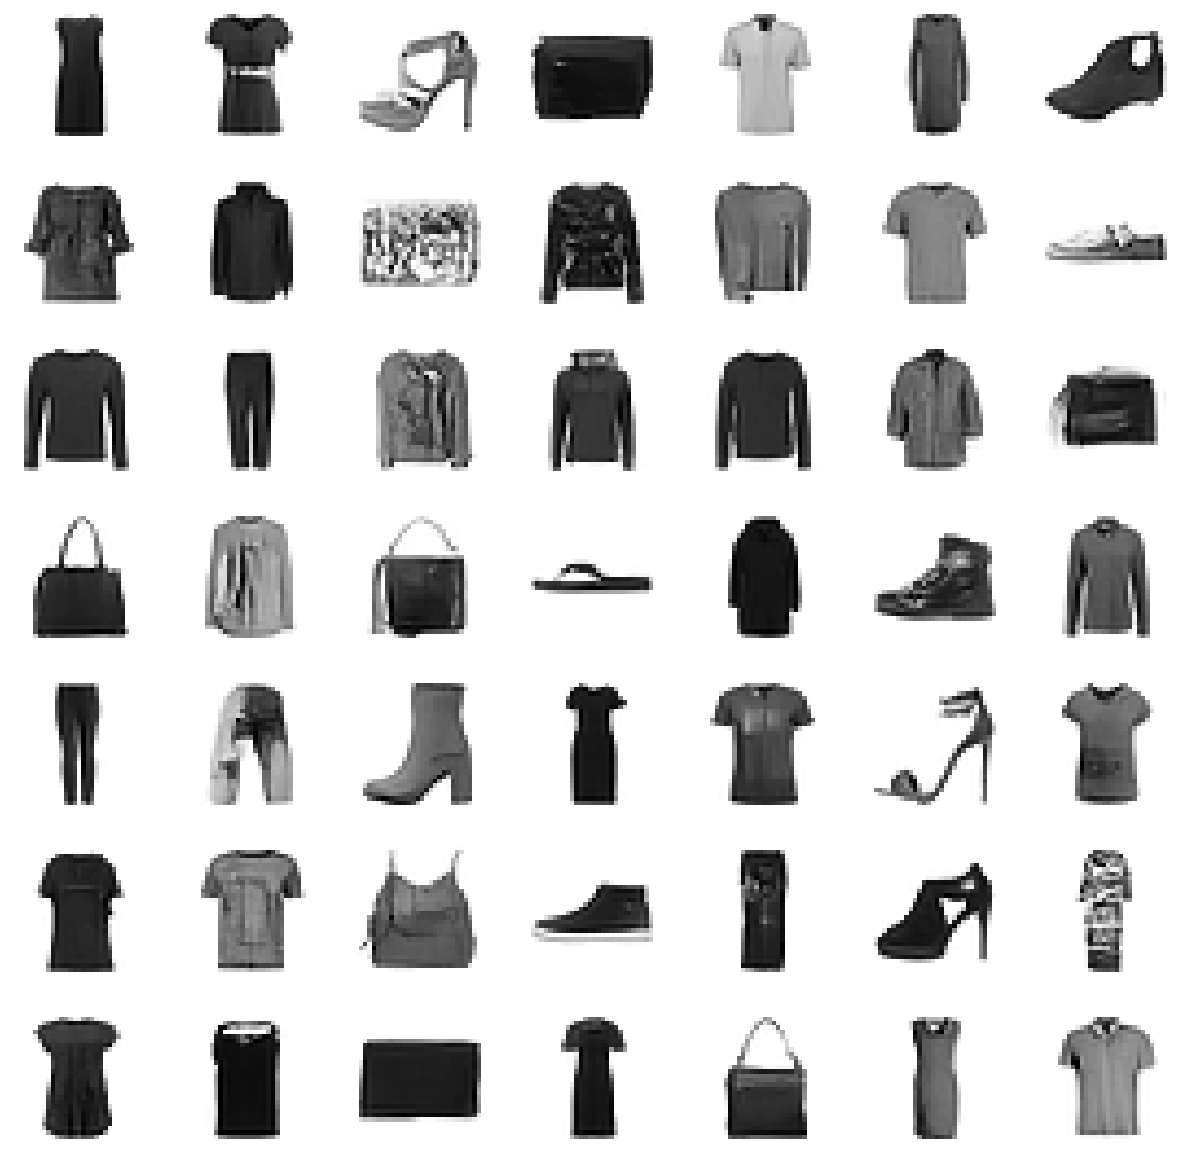

In [16]:
print([(a.min(),a.max()) for a in (preds[-1],)])
show_images(s[:49])

# DDIM implementation
let's go Greek!!!

In [5]:
from types import SimpleNamespace
n_steps =1000
def linear_sched(betamin=1e-4, betamax=0.01, n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    alpha = 1.0 - beta
    return SimpleNamespace(
        alpha = alpha,
        alphabar = alpha.cumprod(dim=0),
        sig=beta.sqrt()
    )

alphabar = linear_sched().alphabar

'''
betabar = 1-alphabar
'''
def ddim_step(x_t, t, pred_noise, alphabar_t, alphabar_tm1, betabar_t, betabar_tm1, eta):
    '''
    variance of the added random noise
    
    eta by default is 1. It's the scaling parameter, set to 0 to make the forward
    deterministic and eliminate any added random noise during the process (and
    also, given the same starting x_t of Gaussian noise, will get deterministic
    generations).
    
    An equivalent way I've seen this written is the variance term omitting eta^2,
    but sig = variance.sqrt() * eta
    '''
    variance=(betabar_tm1 / betabar_t) * (1 - (alphabar_t / alphabar_tm1)) * eta**2
    sig = variance.sqrt()
    
    '''
    x_0_hat = "predicted" x0 (given all information from this step in the process)
    
    Because ddim sampling process uses the same model that was training in the 
    forward pass, x_0_hat is still derived by solving for x_0 from the 
    "noisify" function in the forward pass.
    '''
    x_0_hat = (x_t - betabar_t.sqrt() * pred_noise) / alphabar_t.sqrt()
    x_t = alphabar_tm1.sqrt() * x_0_hat + (betabar_tm1 - sig**2).sqrt() * pred_noise
    if t>0:
        '''
        if eta = 0, sig=0
        '''
        x_t += sig * torch.randn(x_t.shape).to(x_t)
    
    return x_t
    

@torch.no_grad()
def sample(step_fn, model, sz, n_steps, skips=1, eta=1.0):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).cuda()
    preds = []
    for i,t in enumerate(progress_bar(tsteps)):
        '''
        alphabar_(t-1), indexed as i+1 because tsteps is a reversed
        list
        '''
        alphabar_tm1 = alphabar[tsteps[i+1]] if t>0 else torch.tensor(1)
        pred_noise = model(x_t, t).sample
        x_t = step_fn(x_t, t, pred_noise, alphabar[t], alphabar_tm1,
                      1.0-alphabar[t], 1.0-alphabar_tm1, eta)
        preds.append(x_t.float().cpu())
    
    return preds
    

# export MKL_NUM_THREADS=1'

samples=sample(ddim_step, sampling_model, (128, 1, 32, 32), 1000, 10)
s=(samples[-1]*2).clamp(-1,1)

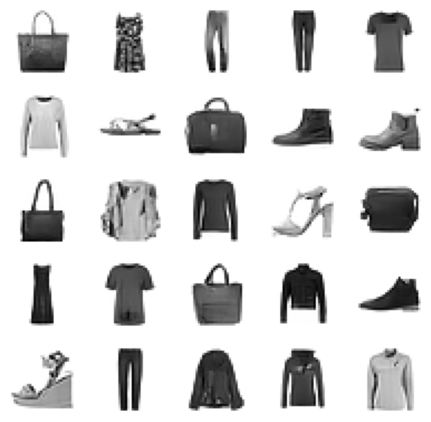

In [6]:
show_images(s[:25], imsize=1.5)

In [7]:
ie.fid(s)

36.04102341256771

In [14]:
from diy_stable_diffusion.fid import _calc_stats,_calc_fid,_calc_kid

In [15]:
feats=ie.get_feats(s)

In [16]:
feats.min(),feats.max(),feats.mean()

(tensor(-1.3669), tensor(9.6326), tensor(0.1872))

In [17]:
ie.feats.min(),ie.feats.max(),ie.feats.mean()

(tensor(-1.3833), tensor(10.2494), tensor(0.2045))

In [18]:
means,covs=_calc_stats(feats)
means.min(),means.max()

(tensor(-0.9518), tensor(1.5959))

In [19]:
covs.min(),covs.max()

(tensor(-2.8718), tensor(7.9878))

In [20]:
ie.stats[0].min(),ie.stats[0].max()

(tensor(-0.9414), tensor(1.5551))

In [21]:
ie.stats[1].min(),ie.stats[1].max()

(tensor(-2.6386), tensor(7.7796))

In [35]:
covs_by_covs = ie.stats[1] @ covs
covs_by_covs.shape

torch.Size([512, 512])

In [25]:
covs_by_covs.min(),covs_by_covs.max()

(tensor(-511.9166), tensor(965.0320))

In [1]:
from scipy import linalg
import torch
from torch import tensor

In [2]:
covs_by_covs = torch.load('models/covsbycovs18.pkl')

In [31]:
covs_by_covs.shape,covs_by_covs.min(),covs_by_covs.max()

(torch.Size([512, 512]), tensor(-436.3926), tensor(719.0269))

In [3]:
size=512
small = covs_by_covs[:size,:size]
print(small.shape)
msqrt = linalg.sqrtm(small, 256)
msqrt.shape

torch.Size([512, 512])


(512, 512)

In [22]:
_calc_fid??

Signature: _calc_fid(means1, covs1, means2, covs2)
Docstring: <no docstring>
Source:   
def _calc_fid(means1, covs1, means2, covs2):
    csr = tensor(linalg.sqrtm(covs1@covs2, 256).real)
    '''
    return (
        ((means1 - means2)**2).sum() +
        covs1.trace() + covs2.trace() - 2*csr.trace()
    ).item()
    '''
    return (((means1-means2)**2).sum() + covs1.trace() + covs2.trace() - 2*csr.trace()).item()
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/fid.py
Type:      function


In [23]:
ie.fid??

Signature: ie.fid(samples)
Docstring: <no docstring>
Source:   
    def fid(self, samples):
        feats = self.get_feats(samples)
        return _calc_fid(*self.stats, *_calc_stats(feats))
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/fid.py
Type:      method


In [ ]:
'''
TODO: why does this crash?
the very first linalg.sqrtm crashes

well after importing a different cov@cov matrix from nb 18 fid,
and running sqrtm on it, which worked, then calculating the 
feats and covs for this nb again, running sqrtm(cov@cov) worked
and calling ie.fid also worked

seems like some kind of systems bug between the console machine
/ cluster (a github issue I've seen reported before indicated
a problem with running on some kind of cluster), pytorch (the
same gh issue reported ill-interactions between scipy and torch),
scipy, and jupyter.

Then I went ahead from scratch to just generate all samples 
again using DDIM and calculating fid just worked. So maybe 
something about importing the other dataset kind of "flushed"
something through.

Now, restarting kernel and going through again without importing
the other matrix, it failed. What was flushed got unflushed?

Then, yet again, I restarted kernel, imported other matrix,
sqrtm'd it, then ran rest of notebook code to generate ie
and samples, and ie.fid(s) worked.

Systems bug! I will certainly give up debugging it now.
'''
ie.fid(s)

In [38]:
ie.kid(s)

-0.055423736572265625

In [21]:
my_feats = ie.get_feats(s)
my_feats.shape

torch.Size([128, 512])

In [22]:
my_stats = _calc_stats(my_feats)

In [23]:
if True:
    import pdb; pdb.set_trace()
    # question: why 
    _calc_fid(*ie.stats, *my_stats)

> /tmp/ipykernel_6281/3040878333.py(3)<cell line: 2>()
      1 if True:
      2     import pdb; pdb.set_trace()
----> 3     _calc_fid(*ie.stats, *my_stats)



ipdb>  step


--Call--
> /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/fid.py(61)_calc_fid()
     59     return feats.mean(0), feats.T.cov()
     60 
---> 61 def _calc_fid(means1, covs1, means2, covs2):
     62     csr = tensor(linalg.sqrtm(covs1@covs2, 256).real)
     63     '''



ipdb>  step


> /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/fid.py(62)_calc_fid()
     60 
     61 def _calc_fid(means1, covs1, means2, covs2):
---> 62     csr = tensor(linalg.sqrtm(covs1@covs2, 256).real)
     63     '''
     64     return (



ipdb>  exit


In [4]:
# cov1 = ie.stats[1]
# cov2 = my_stats[1]
import torch
cov1=torch.randn((512,512))*2
cov2=torch.randn((512,512))
cov1.shape,cov2.shape

(torch.Size([512, 512]), torch.Size([512, 512]))

In [5]:
from scipy import linalg

In [6]:
linalg.sqrtm(cov1@cov2, 256)
(cov1@cov2).shape

torch.Size([512, 512])

In [40]:
ie.stats[1].shape

torch.Size([512, 512])

In [28]:
ie.feats.shape

torch.Size([512, 512])